# John Wu
# CSE 5524
# 10/23/22
### Libraries

In [130]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.animation as animation
import matplotlib.cm as cm
import scipy
import scipy.ndimage
import skimage.io
import operator as op
import itertools as it
from PIL import Image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import morphology
# plt.rcParams['figure.figsize'] = [20, 20]

### 1) Compute and display the Harris pixel-wise cornerness function R values for the image checker.jpg using a) Gaussian window/weighting function with a standard deviation of σ I = 1 (use 3σ mask size), b) Gaussian Gx,Gy gradients with a standard deviation of σ D = 0.7 (use 3σ mask size), and c) trace weighting factor of α = 0.05. (For this assignment, use the Gaussian smoothing and derivative formulas given earlier in class, and normalize the sum of the smoothing mask to 1 and the sum of the abs derivative masks to 1.) Give the values of R(17:23, 17:23) in your report (these coordinates are for Matlab indices, so subtract 1 if using Python). 

### Note: use double() and not im2double() in your Matlab code (as it scales values to 0-1) on checker.jpg.

### Next remove the smaller (and negative) values in R (anything < 1,000,000). Display the thresholded R using imagesc (stretches values to the min/max display graylevel).

### Lastly, do a simple non-maximum suppression on R to identify the actual corner points and display them on the original image. For this version, keep a location only if it is a unique maximum in its 3x3 region. [5 pts]


In [131]:
def dColumnGauss(r,c, centerCol, centerRow, sigma):
    mainTerm = (c- centerCol) / (2 * np.pi * np.power(sigma,4))
    exponentialTerm = np.exp( -((np.square(c- centerCol) + np.square(r-centerRow)) / (2*np.square(sigma))) )
    return mainTerm * exponentialTerm

def dRowGauss(r,c, centerCol, centerRow, sigma):
    mainTerm = (r- centerRow) / (2 * np.pi * np.power(sigma,4))
    exponentialTerm = np.exp( -((np.square(c- centerCol) + np.square(r-centerRow)) / (2*np.square(sigma))) )
    return mainTerm * exponentialTerm


def gaussianDeriv2D(sigma):
    maskDim = (np.ceil(3*sigma)).astype(int)
    maskSize = int(2*maskDim + 1)
    centerRow = int(maskDim)
    centerCol = int(maskDim)
    Gx = np.zeros((maskSize, maskSize))
    Gy = np.zeros((maskSize, maskSize))
    for r in range(maskSize):
        for c in range(maskSize):
            Gx[r, c] = dColumnGauss(r, c, centerCol, centerRow, sigma)
            Gy[r, c] = dRowGauss(r, c, centerCol, centerRow, sigma)
    Sx = np.sum(np.abs(Gx))
    Sy = np.sum(np.abs(Gy))
    Gx = Gx / Sx
    Gy = Gy / Sy
    return Gx, Gy    

def gaussian(x, center, sigma):
    mainTerm = 1 / (np.sqrt(2* np.pi) * (sigma))
    exponentialTerm = np.exp( -np.square(x-center)/(2*sigma*sigma))
    return mainTerm * exponentialTerm

def gaussian_smooth_mask(sigma):
    maskDim = np.ceil(3*sigma) # for this case again we will use 3sigma
    maskSize = 2*int(maskDim) + 1
    center = maskDim
    gX = np.zeros((maskSize,maskSize)) # column
    gY = np.zeros((maskSize,maskSize)) # row (y)
    for r in range(maskSize):
        for c in range(maskSize):
            gX[r,c] = gaussian(c, center, sigma) # col
            gY[r,c] = gaussian(r, center, sigma) # row
            
    gX = gX / np.sum(gX)
    gY = gY / np.sum(gY)
    return [gX, gY]

def gaussian_blur(im, sigma):
    gXblur, gYblur = gaussian_smooth_mask(sigma) 
    retIm = scipy.ndimage.filters.correlate(im, gXblur, mode='nearest')
    retIm = scipy.ndimage.filters.correlate(retIm, gYblur, mode='nearest')
    return retIm

1.0
(7, 7)


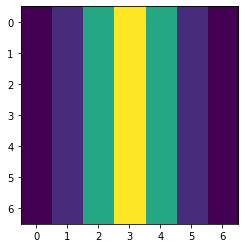

In [132]:
# sanity check
gx, gy = gaussian_smooth_mask(1)
print(np.sum(gx))
print(gx.shape)
plt.imshow(gx)
gx, gy = gaussianDeriv2D(1)

(400, 400)
255.0
0.0


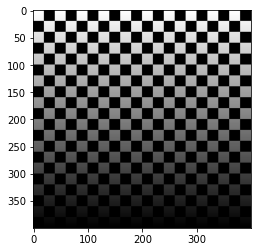

In [133]:
checker = 255*plt.imread('checker.png') # unnormalize after loading img
print(checker.shape)
plt.imshow(checker, cmap='gray')
print(np.max(checker))
print(np.min(checker))

In [134]:
#  scipy.ndimage.filters.correlate(secondBoxIm, sobelX, mode='nearest')
def harris_cornerness(img, sigmaI, sigmaD, alpha):
    # masks to use
    gDX, gDY = gaussianDeriv2D(sigmaD)

    # get Ix, Iy
    Ix = scipy.ndimage.filters.correlate(img, gDX, mode='nearest')
    Iy = scipy.ndimage.filters.correlate(img, gDY, mode='nearest')

    # get Ix^2, Iy^2, Ix*Iy
    Ix_2 = np.square(Ix)
    Iy_2 = np.square(Iy)
    IxIy = np.multiply(Ix, Iy)

    # now gaussian blur all of it.
    gIx_2 = gaussian_blur(Ix_2, sigmaI)
    gIy_2 = gaussian_blur(Iy_2, sigmaI)
    gIxIy = gaussian_blur(IxIy, sigmaI)
    R = np.multiply(gIx_2, gIy_2) - np.square(gIxIy) - alpha * np.square(gIx_2 + gIy_2)
    return R   

In [135]:
sigmaI = 1
sigmaD = 0.7
alpha = 0.05

#### R(17:23, 17:23)/ R(16:22, 16:22) in python is shown below in the grayscale image and saved.

    2.961347500000000000e+06 4.408752500000000000e+06 4.911396000000000000e+06 4.986769500000000000e+06 4.976849500000000000e+06 4.883022000000000000e+06
    4.398238000000000000e+06 6.828598500000000000e+06 7.735011000000000000e+06 7.882061500000000000e+06 7.867990500000000000e+06 7.694696000000000000e+06
    4.879953000000000000e+06 7.704020000000000000e+06 8.773652000000000000e+06 8.950058000000000000e+06 8.934451000000000000e+06 8.728907000000000000e+06
    4.930270000000000000e+06 7.813746500000000000e+06 8.909020000000000000e+06 9.090182000000000000e+06 9.074363000000000000e+06 8.863659000000000000e+06
    4.894679000000000000e+06 7.761695000000000000e+06 8.851193000000000000e+06 9.031530000000000000e+06 9.015882000000000000e+06 8.806324000000000000e+06
    4.776905000000000000e+06 7.553468000000000000e+06 8.606517000000000000e+06 8.780574000000000000e+06 8.765478000000000000e+06 8.563228000000000000e+06


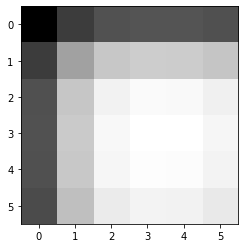

In [136]:
# give the values of R(16:22, 16:22) in report.
R = harris_cornerness(checker, sigmaI, sigmaD, alpha)
plt.imshow(R[16:22, 16:22], cmap='gray')
plt.imsave('p1_r17_23.png', R[16:22, 16:22], cmap='gray')
np.savetxt("p1_r17_23.txt", R[16:22, 16:22])


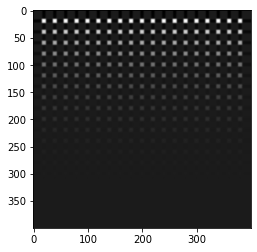

In [137]:
plt.imshow(R, cmap='gray')

#### The thresholded R, anything < 0 is removed.

In [138]:
print(np.max(R))
print(np.min(R))

9090182.0
-1074845.6


9090182.0
0.0


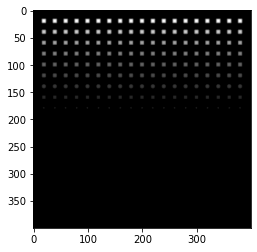

In [139]:
filteredR = R.copy()
# remove less than 1 mil
filteredR[filteredR < 1000000] = 0
plt.imshow(filteredR, cmap='gray')
plt.imsave('p1_thresholded_R.png',filteredR, cmap='gray')
print(np.max(filteredR))
print(np.min(filteredR))

#### Quick Sanity Check Zoom in:

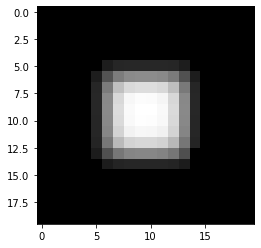

In [140]:
plt.imshow(filteredR[10:30,10:30], cmap='gray')

In [141]:
# returns true if there's a duplicate value inside the matrix by whatever python defines == to be.
def existsDuplicate(nbrhood, val):
    check = nbrhood == val
    return np.sum(check) > 1

# returns true if it is the unique max in its 3x3 region, also includes checking for boundary conditions
def uniqueMax(img, r, c):
    # let's first check if it's on the border.
    neighborhood = 0
    # check boundaries
    if img.shape[0] < 2 or img.shape[1] < 2:
        print("Error! Image is smaller than 3x3! Any results determined are faulty!")
        exit(-1)
    
    # top 
    if r == 0:
        # top rt corner - nearest 3 x 3
        if c == img.shape[1] - 1:
            neighborhood = img[r:r+1,c-1:c]
        # top left corner
        elif c == 0:
            neighborhood = img[r:r+1,c:c+1]
        # just on the top.
        else:
            neighborhood = img[r:r+1, c-1:c+1]
    # bottom
    elif r == img.shape[0] - 1:
        
        # bottom right
        if c == img.shape[1] - 1:
            neighborhood = img[r-1:r+1,c-1:c+1]
        #btm left
        elif c == 0:
            neighborhood = img[r-1:r+1,c:c+2]
        # just on the bottom
        else: 
            neighborhood = img[r-1:r+1,c-1:c+2] 
    else:
        # on the right edge
        if c == img.shape[1] - 1:
            neighborhood = img[r-1:r+2,c-1:c+1]
        # on the left edge
        elif c == 0:
            neighborhood = img[r-1:r+2,c:c+2]
        # not near any edge     
        else:
            neighborhood = img[r-1:r+2,c-1:c+2] # 3 x 3 default neighborhood around r,c
    
    # if max and unique, i.e no duplicates.
    return (np.max(neighborhood) == img[r,c]) and not existsDuplicate(neighborhood, img[r,c])
    
    
# 3x3 nonmax suppression i.e nearest 1 pixel
def nonMaxSuppress(img):
    importantPoints = np.zeros(img.shape)
    # check if each pixel is unique max or not, and if not, set off == 0
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if uniqueMax(img, r, c):
                importantPoints[r,c] = img[r,c]
            
    return importantPoints
    


#### Nonmax Suppression:

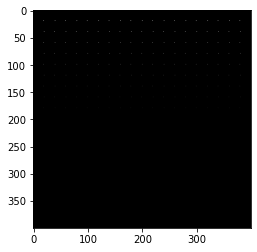

In [142]:
points = nonMaxSuppress(filteredR)
plt.imshow(points, cmap='gray')
plt.imsave('p1_nonmaxsuppress.png', points, cmap='gray')

#### Above may be hard to see because of the color gradient, so let's just binarize it and show that.

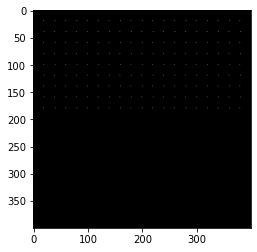

In [143]:
plt.imshow(points > 0, cmap='gray')
plt.imsave('p1_nonmaxsuppressBinary.png', points > 0, cmap='gray')

#### Overlay nonbinary interest points onto original image.

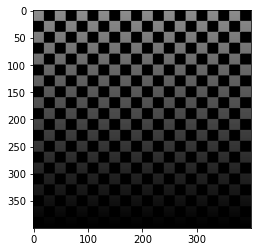

In [144]:
# look I know I could write my own python overlapping image by just overwriting the original image's pixels, but I will use a package for cleanliness.
pil_checker = Image.fromarray(np.uint8(checker))
pil_points = Image.fromarray(np.uint8(points))
new_img = Image.blend(pil_checker, pil_points, 0.5)
new_img.save("overlayed.png","PNG")
Image.fromarray(np.uint8(cm.gist_earth(checker)*255))
plt.imshow(new_img, cmap='gray')

#### Zoom in again, because impossible to see when overlayed!

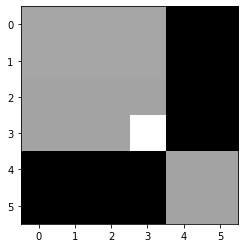

In [145]:
plt.imshow(np.array(new_img)[16:22,16:22], cmap='gray')
plt.imsave('p1_subsetOfOverlayedR.png', np.array(new_img)[16:22,16:22]) # save these new values

#### As a sanity check let's look at multiple corners! This seems to make sense as a "corner" detector!

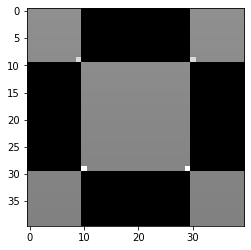

In [146]:
plt.imshow(np.array(new_img)[10:50,10:50], cmap='gray')

In [147]:
# for easier visibility!
def getRowsAndCols(overlay):
    rows = []
    cols = []
    for r in range(overlay.shape[0]):
        for c in range(overlay.shape[1]):
            if overlay[r,c] > 0:
                rows.append(r)
                cols.append(c)
    return rows, cols
def overlayImage(im, overlay, fname="image.png"):
    coordY, coordX = getRowsAndCols(overlay)
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='gray')
    plt.scatter(x=coordX, y=coordY, c='r', s=10)
    plt.savefig(fname)

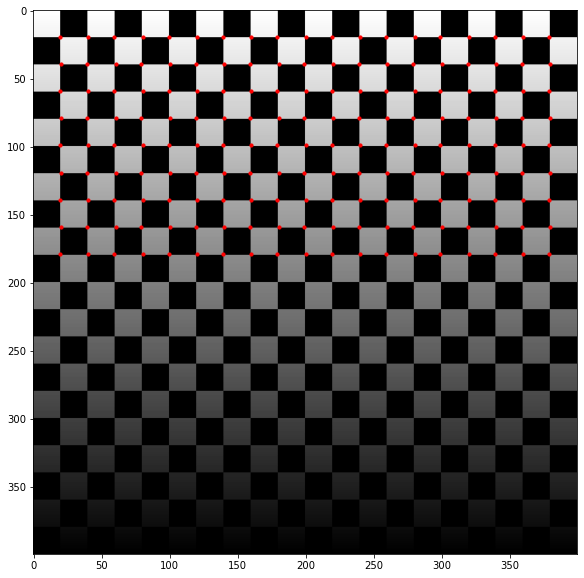

In [148]:
overlayImage(checker, points, fname='p1_overlayed_red.png')

#### Discussion: The above interest points from the harris detector makes sense in the sense that it is finding a corner pixel i.e bottom left of each square in the checkerboard. However, it seems that it is weak to lighting conditions as shown with the missing bottom half (smaller gradient, less bright regions) where although there are visible square corners to the human eye, the detector was unable to decide those to be interest points.

### 2) Implement the FAST feature point detector using a radius of r = 3 (you can hardcode the particular circle border locations), intensity threshold of T = 10, and a consecutive-number-of-points threshold of n* = 9. Run the detector on the image tower.png. Display the image and overlay the FAST feature points. Repeat with T = {20, 30, 50} and compare all four results. [6 pts]

In [149]:
def circularBorder(img, r, c, radius=3):
    # note we only care about 4 diagonal points in r=3 border
    # start with the top 3, and rotate clockwise
    # note that if it is a border pixel, we will only take possible valid lists
    neighborhood = [img[r-3,c-1], img[r-3,c], img[r-3,c+1], img[r-2,c+2], img[r-1,c+3],img[r,c+3], img[r+1,c+3], img[r+2,c+2], img[r+3, c+1], img[r+3,c], img[r+3,c-1], img[r+2,c-2], img[r+1, c-3], img[r, c-3], img[r-1,c-3], img[r-2,c-2]]
    return neighborhood

def getLabelledThresholds(borders, val, T):
    labelledList = []
    # use 0, 1, 2 as class values
    for pixel in borders:
        if pixel < val - T: # below
            labelledList.append(0)    
        elif pixel > val + T: #above
            labelledList.append(1)
        else: # between
            labelledList.append(2)
    # print(labelledList)
    return labelledList

# basically a list of tuples with each corresponding class and their length.
def sequences(l):
    return [(k, sum(1 for _ in g)) for k, g in it.groupby(l)]



def fastDetection(img, T, nStar):
    points = np.zeros(img.shape)
    # hard coded 3 x 3 windows....
    for r in range(3,img.shape[0]-3):
        for c in range(3,img.shape[1]-3):
            type = -1
            borders = circularBorder(img, r, c)
            borderLabels = getLabelledThresholds(borders, img[r,c], T)
            counts = sequences(borderLabels)
            n = 0
            for count in counts:
                if count[0] != 2 and count[1] > n:
                    n= count[1]
            if n >= nStar:
                points[r,c] = 255
    return points 

            

(481, 321)


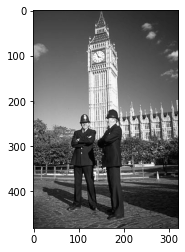

In [150]:
tower = 255*plt.imread('tower.png')
plt.imshow(tower, cmap='gray')
print(tower.shape)

#### T = 10, r = 3, n* =9:

In [151]:
T = 10
nStar = 9
interestPts = fastDetection(tower, T, nStar)

##### Points By Themselves.

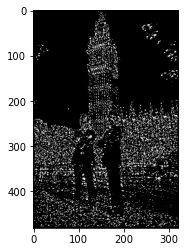

In [152]:
plt.imshow(interestPts, cmap='gray')

##### Overlayed Image T=10:

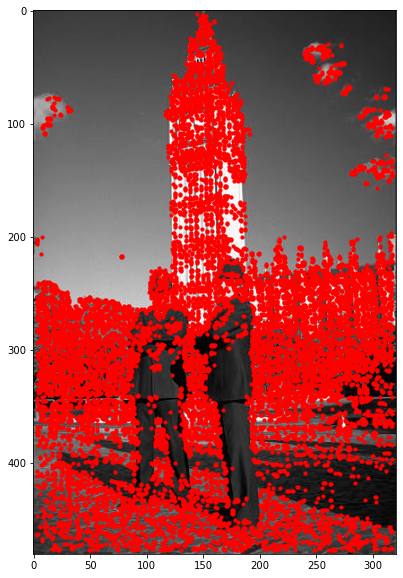

In [153]:
overlayImage(tower,interestPts, fname='p2_overlayedt10.png')


#### T = 20

In [154]:
interestPts20 = fastDetection(tower, 20, nStar)

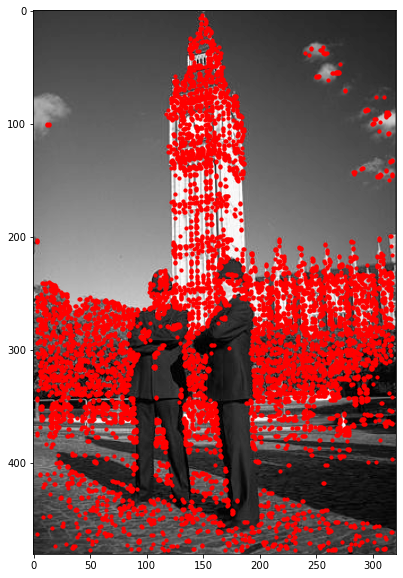

In [155]:
overlayImage(tower, interestPts20,fname='p2_t20.png')

#### T=30

In [156]:
interestPts30 = fastDetection(tower, 30, nStar)

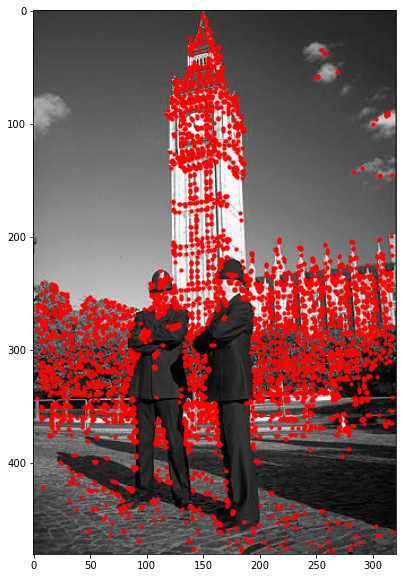

In [157]:
overlayImage(tower, interestPts30, fname='p2_t30.png')

#### T = 50

In [158]:
interestPts50 = fastDetection(tower, 50, nStar)

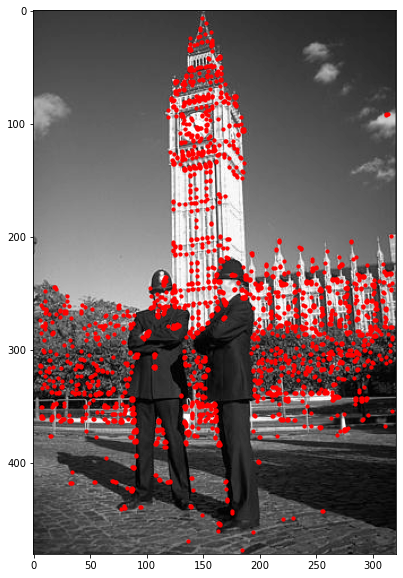

In [159]:
overlayImage(tower, interestPts50, fname='p2_t50.png')

#### Discussion: So quick observation notes as you increase T from 10 to 20 to 30 to 50, all interest points seem to at least occur at some jagged edge or corner (of the tower i.e the pointy bits) or the faces of the figures in front of the tower. Furthermore, as you increase T, the number of interest points decreases where T=10 seems to cover the entire photo while with each iteration of T=10, we get less and less points till T=5 (where you can see the people's bodies). Most of the points make sense being in the grainy bushes or the holes of the towers or if you lower the threshold enough (i.e T=10), points being on the people's arms. As a final note, keep in mind that the points are expanded in size to be visible, if you keep them at one pixel value (i.e their exact specific location), you can't actually see the points.